In [1]:
import os, sys, time, math
from natsort import natsorted #, ns

import numpy as np
import cv2
import matplotlib.pyplot as plt
import cma
# from PIL import Image
import glob
# import re
from tifffile import imwrite
import json 

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
# from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment using Matplotlib

# from gvxrPython3.utils import loadSpekpySpectrum # Generate and load an X-ray spectrum using Spekpy
# from gvxrPython3.utils import loadXpecgenSpectrum # Generate and load an X-ray spectrum using xpecgen



import utils
from utils import average_images, flatField, getReference, displayResult, fitnessMSE, fitnessMAE, getXrayImage, bbox, plot_directory



spekpy is not install, you won't be able to load a beam spectrum using spekpy
SimpleGVXR 2.0.7 (2023-11-06T20:19:42) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 2.0.7 (2023-11-06T20:19:41) [Compiler: Microsoft Visual Studio] on Windows


In [2]:
utils.use_padding = False
utils.pad_width = 50
angular_step_in_deg = 3.6

In [3]:
# data_path = "C:/Users/user/phd/Dataoff/"
# data_path = "C:/Users/user/phd/26SepImages/"
# data_path = "C:/Users/snn23kfl/project/"
#data_path = "4thOCtober_image/"
#data_path = "4thCotober_imageAngle/"
data_path = "25OctoberData/"
#data_path = "15NovemberData/"

In [4]:
current_folder = str(globals()['_dh'][0])
print(current_folder)

json_file = current_folder + "/simulation2.json"

C:\Users\snn23kfl\project


In [5]:
if not os.path.exists(current_folder + "/" + data_path + "/plot1"):
    os.mkdir(data_path + "/plot1")

if not os.path.exists(current_folder + "/" + data_path + "/plot2"):
    os.mkdir(current_folder + "/" + data_path + "/plot2")


In [6]:
#path for my recently acquired images stored in PhD file



dark_field_paths = glob.glob(data_path + '/darkfd/darkfd_*.tiff')
dark_field_paths = natsorted(dark_field_paths, key=lambda y: y.lower())

white_field_paths = glob.glob(data_path + '/whitefd/whitefd_*.tiff')
white_field_paths = natsorted(white_field_paths, key=lambda y: y.lower())

raw_image_paths = glob.glob(data_path + '/raw_images/raw_image_*.tiff')
raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

if len(raw_image_paths) == 0:
    raw_image_paths = glob.glob(data_path + '/rawimages/raw_images_*.jpg')
    raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

In [7]:
#Average the dark field and white field images
I_dark = average_images(dark_field_paths)
I_white = average_images(white_field_paths)

In [8]:
I_raw = []
angles_in_deg = []
for i, fname in enumerate(raw_image_paths):

    angle = angular_step_in_deg * i

    if angle < 360.000001:
        angles_in_deg.append(angular_step_in_deg * i)
        I_raw.append(cv2.imread(fname, 
                               cv2.IMREAD_GRAYSCALE))
    
        if utils.use_padding:
            median_value = np.median(I_raw[-1])
            I_raw[-1] = np.pad(I_raw[-1], (pad_width, pad_width), 'constant', constant_values=(median_value, median_value))

I_raw = np.array(I_raw, dtype=np.single)
# I_raw = average_images(raw_image_paths)

# for image in I_raw:
#     image /= np.mean(image[:,0:200])

# I_white /= np.mean(I_white[:,0:200])
# I_dark /= np.mean(I_dark[:,0:200])

I_flat1 = flatField(I_raw, I_white, I_dark)
I_flat2 = flatField(I_raw, I_white, np.zeros(I_dark.shape))

# Clamp pixel values
I_flat1[I_flat1<0] = 0
I_flat2[I_flat2<0] = 0

I_flat1[I_flat1>1] = 1
I_flat2[I_flat2>1] = 1

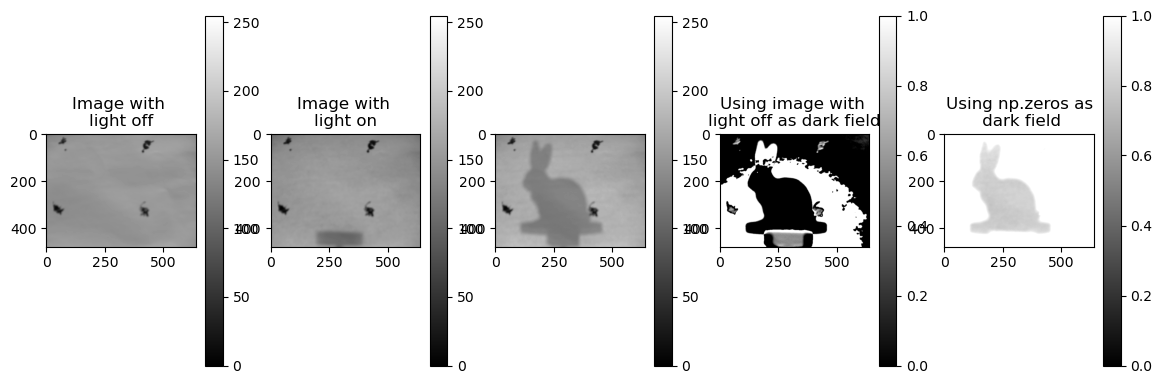

In [9]:
plt.figure(figsize=(14,10))
plt.subplot(2, 5, 1)
plt.title("Image with \nlight off")
plt.imshow(I_dark, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2, 5, 2)
plt.title("Image with \nlight on")
plt.imshow(I_white, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

if len(I_raw.shape) == 2:

    plt.subplot(2, 5, 3)
    plt.imshow(I_raw, cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.imshow(I_flat1, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    
    plt.subplot(2, 5, 5)
    plt.imshow(I_flat2, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
else:
    plt.subplot(2, 5, 3)
    plt.imshow(I_raw[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.title("Using image with \nlight off as dark field")
    plt.imshow(I_flat1[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(2, 5, 5)
    plt.title("Using np.zeros as\n dark field")
    plt.imshow(I_flat2[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()


In [10]:
I_flat = I_flat2

In [11]:
if not os.path.exists(data_path + "/flat_images"):
    os.mkdir(data_path + "/flat_images")

for i, img in enumerate(I_flat):
    imwrite(data_path + "/flat_images/projection_" + str(i).zfill(4) + ".tif", img)

In [12]:
#sod = 43
#sod =47
#sod = 48
#sdd = 61
#for rabbit
#sod=41
#sdd=51
sod=104
sdd=130
#sod = 25
#sdd=61

In [13]:
Ti90Al10 = 5.68
x_src = 0
y_src = -sod
z_src = 0

x_det = 0
y_det = (sdd - sod)
z_det = 0

x_rot = 0
y_rot = 5
z_rot = 0

x_obj = 0
y_obj = 5
z_obj = 0

alpha_x = 0 
alpha_y = 0
alpha_z = 0

x_default = [
    x_src,
    y_src,
    z_src,

    x_det,
    y_det,
    z_det,

    x_rot,
    y_rot,
    z_rot,
    
    x_obj,
    y_obj,
    z_obj,

]

In [14]:
# Initialise gVXR using our JSON file
json2gvxr.initGVXR(json_file, "OPENGL", 3, 2)

Create an OpenGL context: 800x600


In [15]:
# Load our source properties
json2gvxr.initSourceGeometry()
json2gvxr.initSpectrum(verbose=0)

gvxr.setSourcePosition(x_src, y_src, z_src, "mm")

Set up the beam
	Source position: [0.0, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [16]:
# Load our detector
json2gvxr.initDetector()
    # "NumberOfPixels": [2880, 2880],

gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

if utils.use_padding:
    number_of_pixels = gvxr.getDetectorNumberOfPixels();
    gvxr.setDetectorNumberOfPixels(number_of_pixels[0] + 2 * pad_width, number_of_pixels[1] + 2 * pad_width);

Set up the detector
	Detector position: [0.0, 0.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [640, 480]
	Detector number of pixels: [640, 480]
	Pixel spacing: [0.23, 0.23, 'mm']


In [17]:
# Load our samples
json2gvxr.initSamples(json_file, verbose=0)


# bbox = gvxr.getNodeAndChildrenBoundingBox("Rabbit", "cm");


# gvxr.translateNode("Rabbit", 
#                    -(bbox[3] + bbox[0]) / 2, 
#                    -(bbox[4] + bbox[1]) / 2, 
#                    -(bbox[5] + bbox[2]) / 2, 
#                    "cm" )

# gvxr.applyCurrentLocalTransformation("Rabbit");
# gvxr.saveSTLfile("Rabbit", "/home/fpvidal/PROGRAMMING/GitHub/MyProjects/Rabbit.stl");

# print(bbox)


# /home/fpvidal/PROGRAMMING/GitHub/MyProjects/Rabbit.stl


gvxr.setDensity("cuboid", Ti90Al10, "g/cm3")

In [18]:
# ID = "cuboid"
# gvxr.rotateNode(ID, 90, 1.0, 0.0, 0.0)
# gvxr.moveToCentre()
# gvxr. applyCurrentLocalTransformation(ID)

# alpha_x = 0
# alpha_y = 0
# alpha_z = 0

# x_obj = 0
# y_obj = 0
# z_obj = 0

In [19]:
gvxr.computeXRayImage();
gvxr.displayScene()
gvxr.setZoom(1300.3316345214844)
gvxr.setSceneRotationMatrix([-0.6970537900924683, -0.06923084706068039, 0.7136681079864502, 0.0, 0.049960292875766754, 0.988217830657959, 0.14466075599193573, 0.0, -0.715275764465332, 0.13649176061153412, -0.685382068157196, 0.0, 0.0, 0.0, 0.0, 1.0])

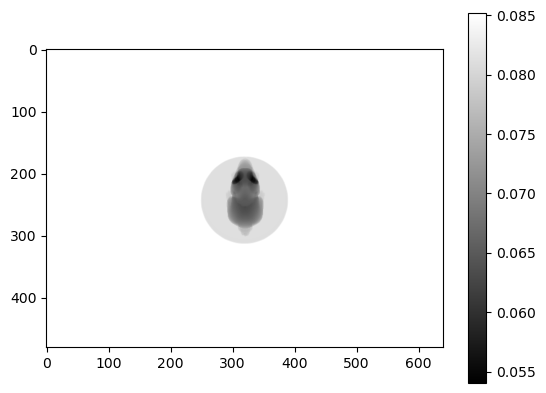

In [20]:
# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(), cmap="gray")
plt.colorbar()
plt.show()

In [21]:
utils.ref_image, utils.selected_angles, utils.indices = getReference(I_flat, angles_in_deg, 1)

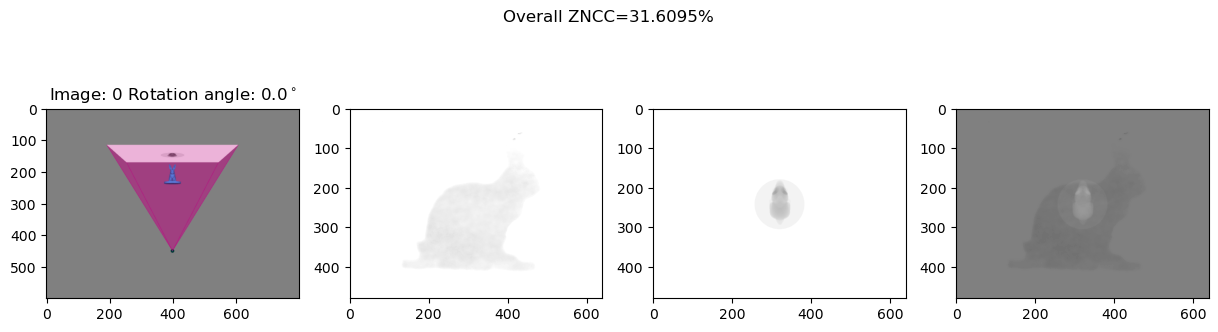

In [22]:
displayResult(x_default)

In [23]:
utils.ref_image, utils.selected_angles, utils.indices = getReference(I_flat, angles_in_deg, 4)

In [24]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-3;
# opts['bounds'] = [np.hstack((12*[-1000], 3*[-180])), np.hstack((12*[1000], 3*[180]))];
opts['bounds'] = [[-200, -1000, -200, 
                   -200,    0, -200, 
                   -200, -200, -200, 
                   -200, -200, -200],
                  
                  [ 200,     0,  200, 
                   200, 1000, 200,
                   200, 200, 200,
                   200, 200, 200]];

x_fname       = current_folder + "/" + data_path + "/x_best1.dat"
fitness_fname = current_folder + "/" + data_path + "/fitness_set1.npz"
utils.plot_directory = current_folder + "/" + data_path + "/plot1"

if not os.path.exists(x_fname) or not os.path.exists(fitness_fname):
    
    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1

    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_default, 0.5, opts);
    es.optimize(fitnessMSE);
    elapsed_time = time.time() - start_time

    x_best1 = es.result.xbest
    np.savetxt(x_fname, es.result.xbest)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savez(fitness_fname, utils.fitness_set)

    
else:
    x_best1 = np.loadtxt(x_fname)
    data = np.load(fitness_fname)
    lst = data.files
    utils.fitness_set = data[lst[0]]

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=110630, Wed Nov 15 16:43:48 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 4.543091170489788e-03 1.0e+00 4.89e-01  5e-01  5e-01 0:07.7
    2     22 4.516219720244408e-03 1.2e+00 4.91e-01  5e-01  5e-01 0:13.9
    3     33 4.494816996157169e-03 1.2e+00 5.06e-01  5e-01  5e-01 0:18.3
    4     44 4.480015020817518e-03 1.3e+00 5.82e-01  6e-01  6e-01 0:28.2
    5     55 4.466569051146507e-03 1.3e+00 6.75e-01  6e-01  7e-01 0:41.2
    6     66 4.442828707396984e-03 1.4e+00 8.11e-01  8e-01  9e-01 0:49.6
    8     88 4.404252860695124e-03 1.4e+00 1.03e+00  1e+00  1e+00 1:01.2
    9     99 4.331709351390600e-03 1.4e+00 1.24e+00  1e+00  1e+00 59:54.0
   10    110 4.264074377715588e-03 1.5e+00 1.59e+00  1e+00  2e+00 104:57.4
   11    121 4.204006865620613e-03 1.5e+00 1.93e+00  2e+00  2e+00 105:07.3
   13    143 4.166598431766033e-03 1.5e+00 2.51e+00  2e+00  3e+00 105:17.4
   17    187 4.13021445274

Text(0, 0.5, 'Fitness value (MSE)')

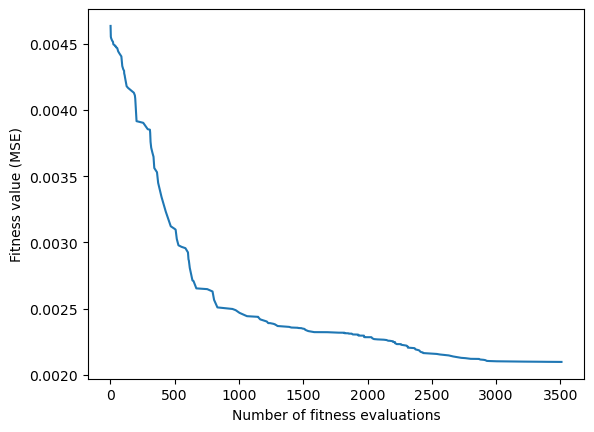

In [25]:
plt.plot(utils.fitness_set[:,0], utils.fitness_set[:,1])
plt.xlabel("Number of fitness evaluations")
plt.ylabel("Fitness value (MSE)")

In [26]:
print(x_best1)

[  83.7816234  -195.02148414  -28.05062506 -193.33316394  426.12228595
   -2.10129652   66.46154843   60.61536783    2.06958601  -65.52002067
  -57.65417772  -26.44933093]


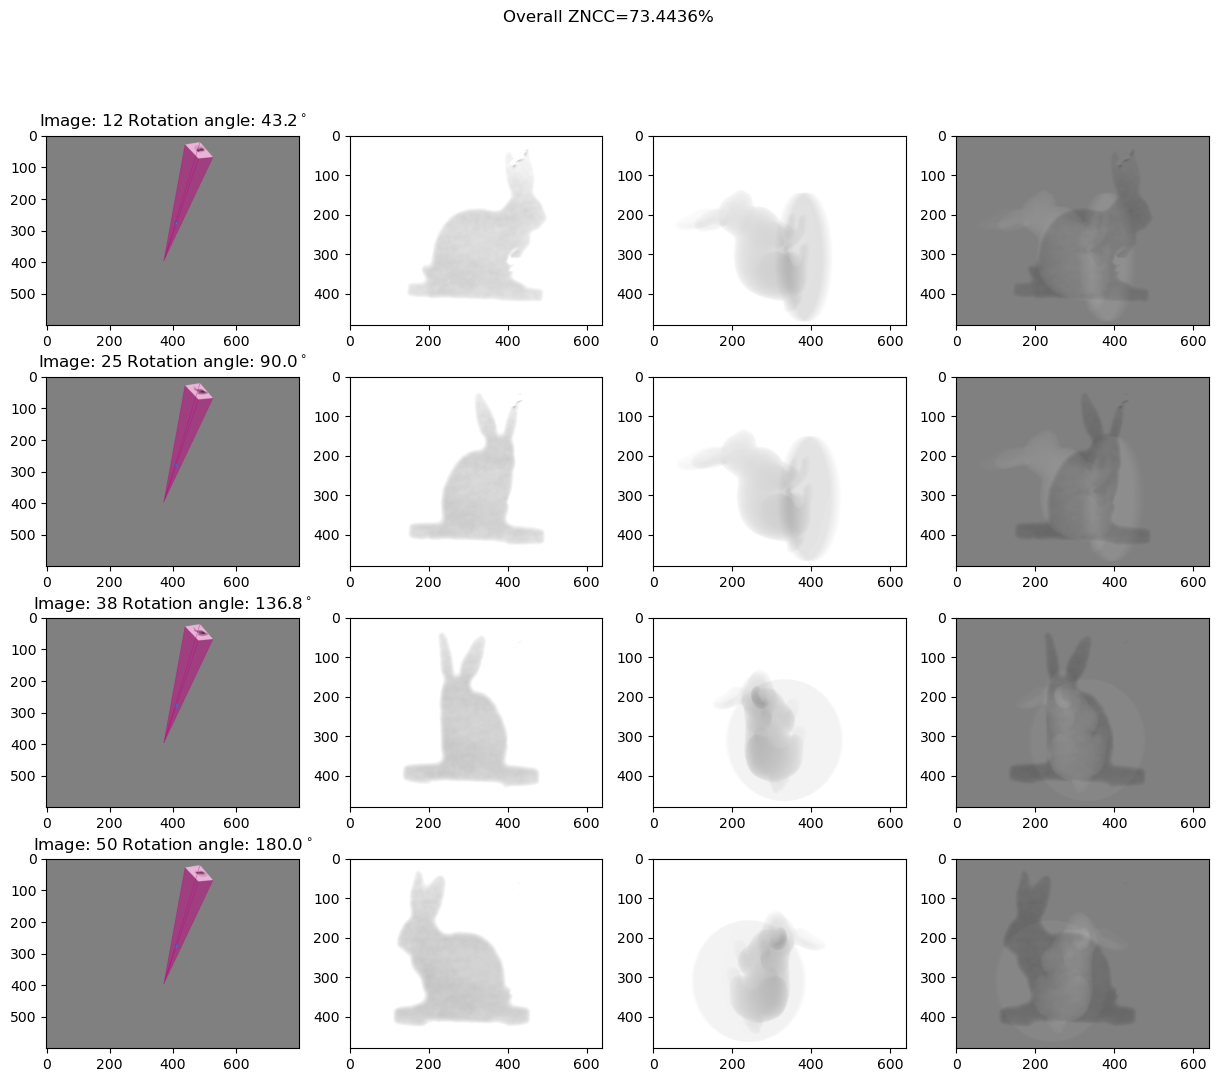

In [27]:
displayResult(x_best1, figsize=(15, 12))

In [28]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-4;
# opts['bounds'] = [np.hstack((12*[-1000], 3*[-180])), np.hstack((12*[1000], 3*[180]))];
opts['bounds'] = [[-200, -1000, -200,
                   -200,    0, -200, 
                   -200, -200, -200,
                   -200, -200, -200, 
                   -180, -180, -180],
                  [ 200,     0,  200,  200, 1000, 200, 200, 200, 200, 200, 200, 200, 180, 180, 180]];

x_fname       = current_folder + "/" + data_path + "/x_best2.dat"
fitness_fname = current_folder + "/" + data_path + "/fitness_set2.npz"
utils.plot_directory = current_folder + "/" + data_path + "/plot2"

if not os.path.exists(x_fname) or not os.path.exists(fitness_fname):
    
    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1

    start_time = time.time();
    x_start = np.hstack([x_best1, [alpha_x, alpha_y, alpha_z,]])
    es = cma.CMAEvolutionStrategy(x_start, 0.5, opts);
    es.optimize(fitnessMSE);
    elapsed_time = time.time() - start_time

    x_best2 = es.result.xbest
    np.savetxt(x_fname, es.result.xbest)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savez(fitness_fname, utils.fitness_set)

    
else:
    x_best2 = np.loadtxt(x_fname)
    data = np.load(fitness_fname)
    lst = data.files
    utils.fitness_set = data[lst[0]]

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=141553, Wed Nov 15 18:45:17 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 2.116397721692920e-03 1.0e+00 4.53e-01  4e-01  5e-01 0:10.2
    2     24 2.137449337169528e-03 1.1e+00 4.34e-01  4e-01  4e-01 0:12.0
    3     36 2.106396015733480e-03 1.2e+00 4.29e-01  4e-01  4e-01 0:20.2
    5     60 2.102227183058858e-03 1.3e+00 3.93e-01  4e-01  4e-01 0:26.6
    7     84 2.099050208926201e-03 1.3e+00 3.81e-01  4e-01  4e-01 0:33.1
   10    120 2.101144054904580e-03 1.5e+00 3.23e-01  3e-01  3e-01 0:38.6
   14    168 2.100821351632476e-03 1.7e+00 2.69e-01  2e-01  3e-01 0:46.0
   18    216 2.098417142406106e-03 1.8e+00 2.17e-01  2e-01  2e-01 0:56.3
   21    252 2.097494900226593e-03 1.9e+00 2.09e-01  2e-01  2e-01 1:04.8
   25    300 2.099416218698025e-03 2.0e+00 2.03e-01  2e-01  2e-01 1:15.0
   29    348 2.098145894706249e-03 2.2e+00 1.93e-01  2e-01  2e-01 1:25.2
   34    408 2.097638556733727e-0

Text(0, 0.5, 'Fitness value (MSE)')

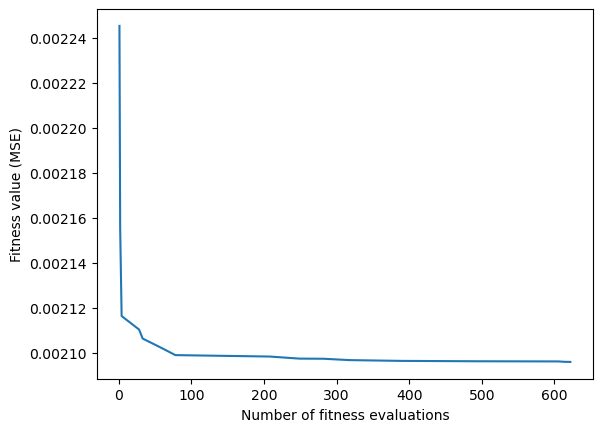

In [29]:
plt.plot(utils.fitness_set[:,0], utils.fitness_set[:,1])
plt.xlabel("Number of fitness evaluations")
plt.ylabel("Fitness value (MSE)")

In [30]:
print(x_best2)

[ 8.42731209e+01 -1.94391170e+02 -2.78864511e+01 -1.94325308e+02
  4.25483753e+02 -2.41937395e+00  6.50380522e+01  6.00986900e+01
  1.27354191e+00 -6.40923682e+01 -5.70079903e+01 -2.57882634e+01
 -1.22713831e+00 -1.88738739e-01 -1.56236914e+00]


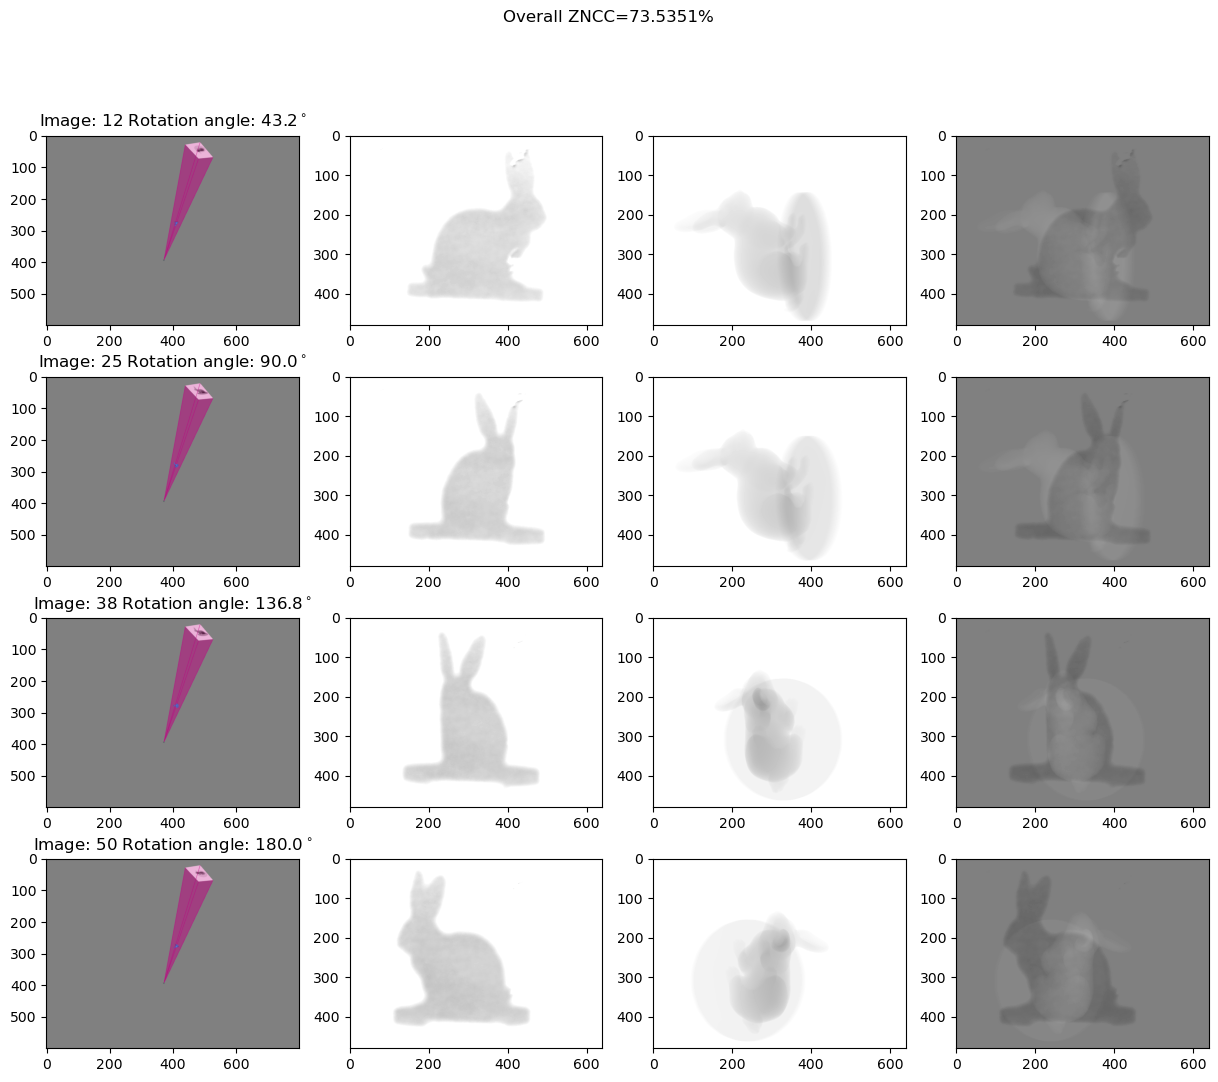

In [31]:
displayResult(x_best2, figsize=(15, 12))

In [32]:
utils.ref_image, utils.selected_angles, utils.indices = getReference(I_flat, angles_in_deg, 7)

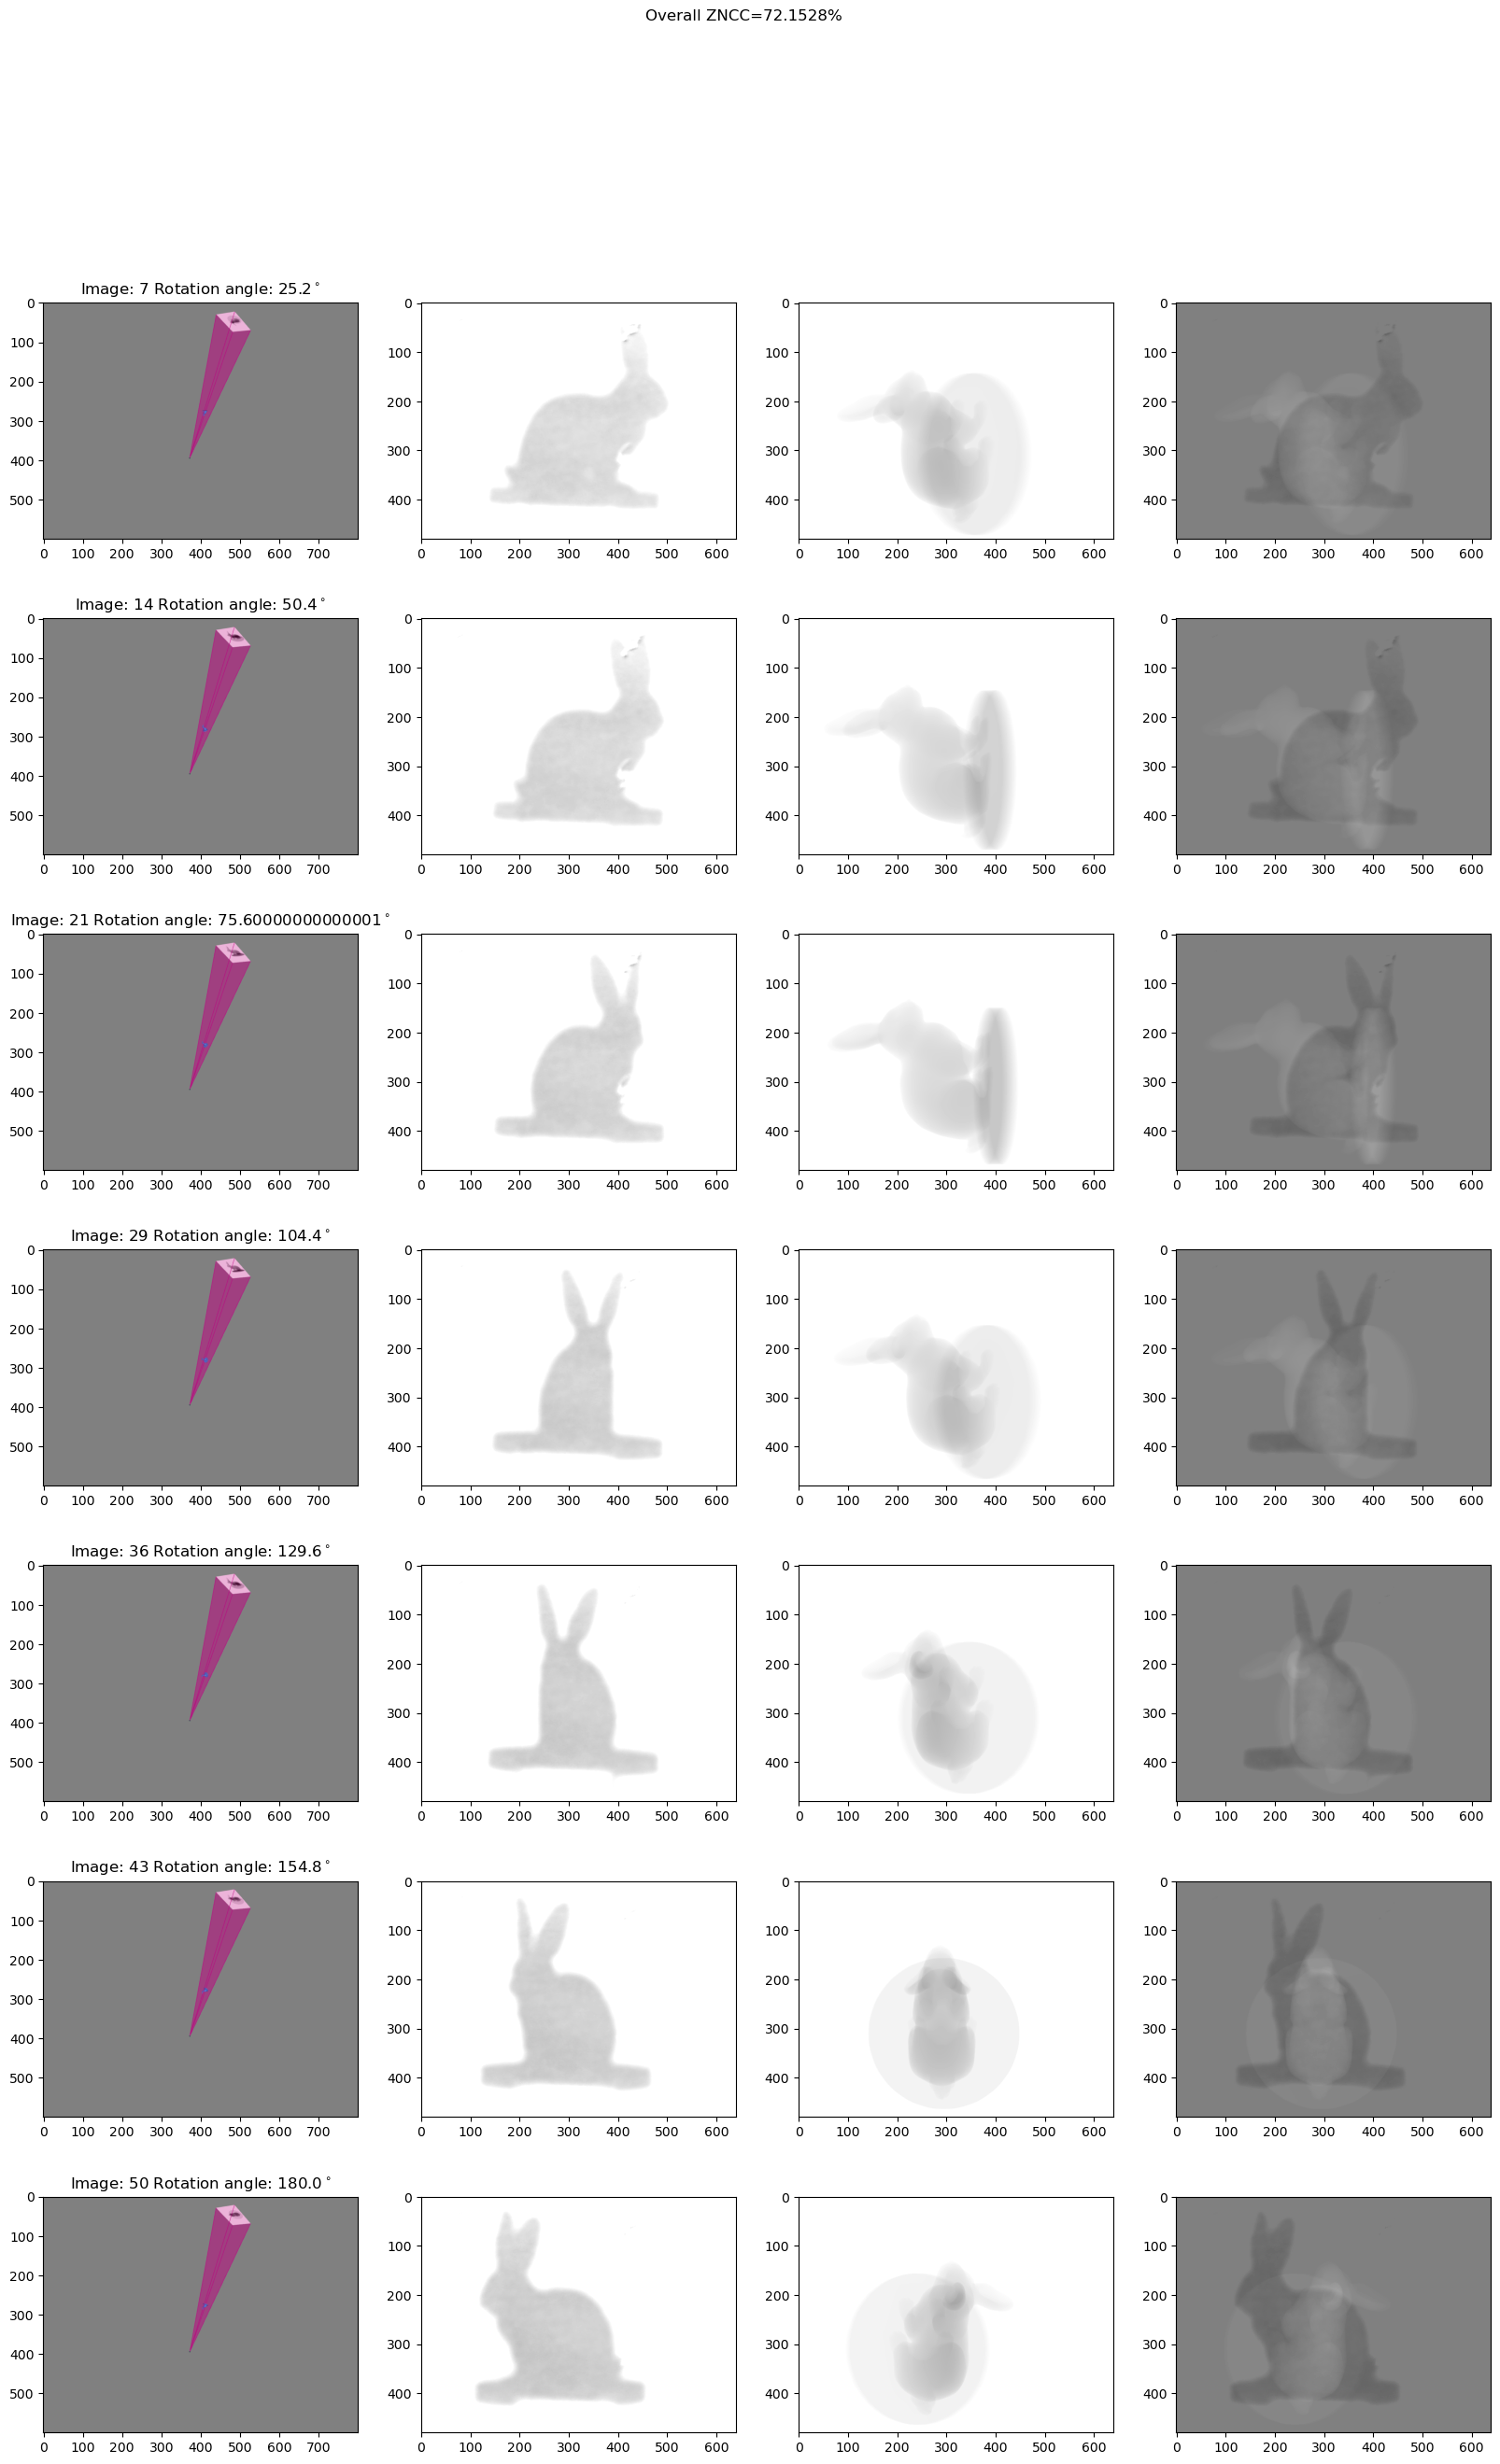

In [33]:
displayResult(x_best1, figsize=(20,30))

In [34]:
# utils.ref_image, utils.selected_angles, utils.indices = getReference(I_flat, angles_in_deg, 101)

In [35]:
def getCentreOfRotationPosition(x):
    
    return np.array([(bbox[0] + bbox[3]) / 2,
                    (bbox[1] + bbox[4]) / 2,
                    (bbox[2] + bbox[5]) / 2])

def getSourcePosition(x):
    return [x[0], x[1], x[2]]
    
def getDetectorPosition(x):
    return [x[3], x[4], x[5]]
    
    
def printX(x):

    # Move source, det, object using x
    x_src = x[0]
    y_src = x[1]
    z_src = x[2]
    
    x_det = x[3]
    y_det = x[4]
    z_det = x[5]

    x_obj1 = x[6]
    y_obj1 = x[7]
    z_obj1 = x[8]

    # alpha_x = x[9]
    # alpha_y = x[10]
    # alpha_z = x[11]

    x_obj2 = x[12]
    y_obj2 = x[13]
    z_obj2 = x[14]


    print("Source position:", getSourcePosition(x), "mm")
    print("Detector position:", getDetectorPosition(x), "mm")
    print("Source-Detector Distance (SDD):", math.sqrt(math.pow(x_src - x_det, 2) + math.pow(y_src - y_det, 2) + math.pow(z_src - z_det, 2)), "mm")
    print("Object position:", x_obj2, y_obj2, z_obj2, "mm")
    print("Centre of rotation position:", getCentreOfRotationPosition(x), "mm")
    
printX(x_best3)

NameError: name 'x_best3' is not defined

In [ ]:



def saveJSON(x, fname, image_path):

    alpha_x = x[9]
    alpha_y = x[10]
    alpha_z = x[11]

    x_obj = x[12]
    y_obj = x[13]
    z_obj = x[14]

    dictionary = {}

    dictionary["WindowSize"] = [800, 600]
    dictionary["Detector"] = {}
    dictionary["Detector"]["Position"] = [
        getDetectorPosition(x)[0],
        getDetectorPosition(x)[1],
        getDetectorPosition(x)[2],
        "mm"]
    dictionary["Detector"]["UpVector"] = gvxr.getDetectorUpVector()
    dictionary["Detector"]["NumberOfPixels"] = gvxr.getDetectorNumberOfPixels()
    dictionary["Detector"]["Size"] = [
        gvxr.getDetectorSize("mm")[0],
        gvxr.getDetectorSize("mm")[1],
        "mm"]

    dictionary["Source"] = {}
    dictionary["Source"]["Position"] = [
        getSourcePosition(x)[0],
        getSourcePosition(x)[1],
        getSourcePosition(x)[2],
        "mm"]
    dictionary["Source"]["Shape"] = "PointSource"
    dictionary["Source"]["Beam"] = []
    
    for energy, count in zip(gvxr.getEnergyBins("keV"), gvxr.getPhotonCountEnergyBins()):
        dictionary["Source"]["Beam"].append({})
        dictionary["Source"]["Beam"][-1]["Energy"] = energy
        dictionary["Source"]["Beam"][-1]["Unit"] = "keV"
        dictionary["Source"]["Beam"][-1]["PhotonCount"] = count

    dictionary["Samples"] = []
    
    for mesh in json2gvxr.params["Samples"]:
        dictionary["Samples"].append({})
        dictionary["Samples"][-1]["Label"] = mesh["Label"]
        dictionary["Samples"][-1]["Path"] = "../" + mesh["Path"]
        dictionary["Samples"][-1]["Unit"] = mesh["Unit"]
        dictionary["Samples"][-1]["Material"] = mesh["Material"]
        dictionary["Samples"][-1]["Density"] = mesh["Density"]
    
        # dictionary["Samples"][-1]["Transform"] = []
        # dictionary["Samples"][-1]["Transform"].append(["Translation", x_obj, y_obj, z_obj, "mm"])
        # dictionary["Samples"][-1]["Transform"].append(["Rotation", alpha_x, 1, 0, 0])
        # dictionary["Samples"][-1]["Transform"].append(["Rotation", alpha_y, 0, 1, 0])
        # dictionary["Samples"][-1]["Transform"].append(["Rotation", alpha_z, 0, 0, 1])
    
    dictionary["Scan"] = {}
    rot_centre = getCentreOfRotationPosition(x)
    dictionary["Scan"]["CenterOfRotation"] = [
        rot_centre[0],
        rot_centre[1],
        rot_centre[2],
        "mm"]
    
    dictionary["Scan"]["FinalAngle"] = (I_flat.shape[0] - 1) * 3.6
    dictionary["Scan"]["IncludeFinalAngle"] = True
    dictionary["Scan"]["NumberOfProjections"] = I_flat.shape[0]
    dictionary["Scan"]["GifPath"] = "preview.gif"
    dictionary["Scan"]["OutFolder"] = image_path
    dictionary["Scan"]["Flat-Field Correction"] = True
    
    
    # Convert and write JSON object to file
    with open(fname, "w") as outfile: 
        json.dump(dictionary, outfile, indent = 4)


visible_light_CT_json_file = current_folder + "/" + data_path + "/visible_light.json"
simulated_CT_json_file = current_folder + "/" + data_path + "/simulation.json"

saveJSON(x_best3, visible_light_CT_json_file, "flat_images/")
saveJSON(x_best3, simulated_CT_json_file,     "simulation/")

In [ ]:
# gvxr.renderLoop()

In [ ]:
gvxr.getZoom()
# gvxr.setSceneRotationMatrix([-0.6970537900924683, -0.06923084706068039, 0.7136681079864502, 0.0, 0.049960292875766754, 0.988217830657959, 0.14466075599193573, 0.0, -0.715275764465332, 0.13649176061153412, -0.685382068157196, 0.0, 0.0, 0.0, 0.0, 1.0])